Melike Çakmakoğlu
2212721048
Makine Öğrenmesi
Proje 1 - model1 (Transfer Learning)
TODO

## Yol ve sınıf tanımları

## Hücre 1 – Drive’ı bağla

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Hücre 2 – Yol ve sınıf tanımları

In [8]:
import os

# Ham veri (senin mevcut klasörün)
raw_base = '/content/drive/MyDrive/Colab Notebooks/Makine_Ogrenmesi/project-1/dataset'

# Train/Val/Test için yeni klasör
split_base = '/content/drive/MyDrive/Colab Notebooks/Makine_Ogrenmesi/project-1/dataset_split'

classes = ['machine_screw', 'wood_sheet_metal_screw']

print("Ham veri klasörü:", raw_base)
print("Bölünmüş veri klasörü:", split_base)
print("Sınıflar:", classes)


Ham veri klasörü: /content/drive/MyDrive/Colab Notebooks/Makine_Ogrenmesi/project-1/dataset
Bölünmüş veri klasörü: /content/drive/MyDrive/Colab Notebooks/Makine_Ogrenmesi/project-1/dataset_split
Sınıflar: ['machine_screw', 'wood_sheet_metal_screw']


## Hücre 3 – Ham veriyi train/val/test olarak böl

In [9]:
import shutil, random

random.seed(42)

# Klasörleri oluştur
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(split_base, split, cls), exist_ok=True)

# İçerikleri kopyala
for cls in classes:
    src_folder = os.path.join(raw_base, cls)
    images = [f for f in os.listdir(src_folder)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    images.sort()
    random.shuffle(images)

    n_total = len(images)   # 63
    n_test = 13
    n_val = 10
    n_train = n_total - n_test - n_val  # 40

    test_imgs = images[:n_test]
    val_imgs = images[n_test:n_test + n_val]
    train_imgs = images[n_test + n_val:]

    print(cls, " -> train:", len(train_imgs),
          "val:", len(val_imgs),
          "test:", len(test_imgs))

    for fname in train_imgs:
        shutil.copy(
            os.path.join(src_folder, fname),
            os.path.join(split_base, 'train', cls, fname)
        )

    for fname in val_imgs:
        shutil.copy(
            os.path.join(src_folder, fname),
            os.path.join(split_base, 'val', cls, fname)
        )

    for fname in test_imgs:
        shutil.copy(
            os.path.join(src_folder, fname),
            os.path.join(split_base, 'test', cls, fname)
        )


machine_screw  -> train: 40 val: 10 test: 13
wood_sheet_metal_screw  -> train: 40 val: 10 test: 13


## Hücre 4 – Bölünmüş veri sayısını kontrol et

In [10]:
for split in ['train', 'val', 'test']:
    for cls in classes:
        folder = os.path.join(split_base, split, cls)
        print(split, cls, "->", len(os.listdir(folder)))


train machine_screw -> 40
train wood_sheet_metal_screw -> 40
val machine_screw -> 10
val wood_sheet_metal_screw -> 10
test machine_screw -> 13
test wood_sheet_metal_screw -> 13


## Hücre 5 – ImageDataGenerator ve generator’lar

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 16

train_dir = os.path.join(split_base, 'train')
val_dir   = os.path.join(split_base, 'val')
test_dir  = os.path.join(split_base, 'test')

train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen   = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen  = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Train samples:", train_generator.samples)
print("Val samples:", val_generator.samples)
print("Test samples:", test_generator.samples)
print("Class indices:", train_generator.class_indices)


Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Train samples: 80
Val samples: 20
Test samples: 26
Class indices: {'machine_screw': 0, 'wood_sheet_metal_screw': 1}


## Hücre 6 – VGG16 tabanını kur (transfer learning)

In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

base_model.trainable = False  # İlk aşamada tamamen donuk
print("VGG16 katman sayısı:", len(base_model.layers))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG16 katman sayısı: 19


## Hücre 7 – Üst sınıflandırıcı bloğu + tam model

In [13]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Hücre 8 – Derleme ve EarlyStopping tanımı

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_accuracy',   # doğruluğu izle
    patience=3,
    restore_best_weights=True
)


## Hücre 9 – Model1’i eğit (train + val)

In [15]:
EPOCHS = 30

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop]
)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5405 - loss: 0.7702 - val_accuracy: 0.5000 - val_loss: 0.7021
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4892 - loss: 0.7454 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.4189 - loss: 0.7523 - val_accuracy: 0.5000 - val_loss: 0.6851
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5392 - loss: 0.7303 - val_accuracy: 0.5000 - val_loss: 0.6784


## Hücre 10 – Eğitim / doğrulama doğruluk ve kayıp grafikleri

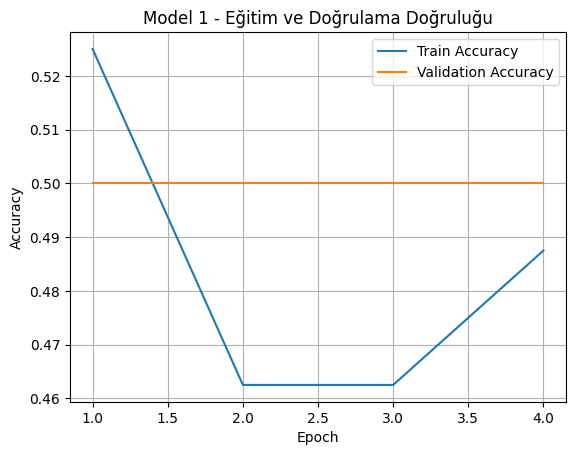

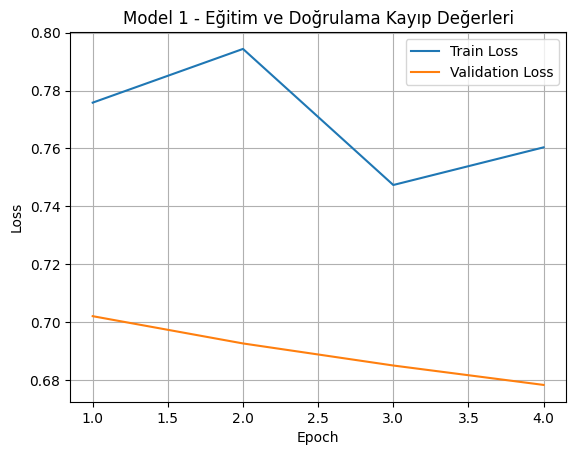

In [16]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1 - Eğitim ve Doğrulama Doğruluğu')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1 - Eğitim ve Doğrulama Kayıp Değerleri')
plt.legend()
plt.grid(True)
plt.show()


## Hücre 11 – Gerçek test setinde performans

In [17]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Model1 - Test loss: {test_loss:.4f}")
print(f"Model1 - Test accuracy: {test_acc:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 5s/step - accuracy: 0.6042 - loss: 0.6941
Model1 - Test loss: 0.7311
Model1 - Test accuracy: 0.5000


## Hücre 12 – Özet bilgi

In [18]:
print("En yüksek validation accuracy:",
      max(history.history['val_accuracy']))


En yüksek validation accuracy: 0.5


## Hücre 13 - Üst sınıflandırıcı bloğunu güçlendir (Flatten + daha fazla Dense)

In [19]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# 1) Base model
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
base_model.trainable = False

# 2) Üst blok (Flatten + iki Dense)
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

x = base_model(inputs, training=False)
x = layers.Flatten()(x)                 # GAP yerine Flatten
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.summary()

# 3) Derleme
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4) EarlyStopping (val_accuracy'yi izle)
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# 5) Eğitim
EPOCHS = 30

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop]
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,845,250 (64.26 MB)

 Trainable params: 2,130,562 (8.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.4304 - loss: 1.0049 - val_accuracy: 0.6500 - val_loss: 0.6426
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.4694 - loss: 0.9625 - val_accuracy: 0.6500 - val_loss: 0.6306
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.5524 - loss: 0.7972 - val_accuracy: 0.6500 - val_loss: 0.6004
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.5365 - loss: 0.7227 - val_accuracy: 0.7500 - val_loss: 0.5894
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6483 - loss: 0.5703 - val_accuracy: 0.7000 - val_loss: 0.5920
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6483 - loss: 0.6824 - val_accuracy: 0.7500 - val_loss: 0.5837
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6184 - loss: 0.6361 - val_accuracy: 0.7000 - val_loss: 0.5776
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.5609 - loss: 0.6575 - val_accuracy: 0.7000 - val_loss: 0.5674
Epoch 9/

## Hücre 14 - Test Setini Yeniden Değerlendirme

In [20]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Model1 (VGG16) - Test loss: {test_loss:.4f}")
print(f"Model1 (VGG16) - Test accuracy: {test_acc:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5513 - loss: 0.6818
Model1 (VGG16) - Test loss: 0.6616
Model1 (VGG16) - Test accuracy: 0.5769


## Hücre 15 - Dropout’u yumuşat (kafayı biraz serbest bırak)

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# 1) Base model
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
base_model.trainable = False

# 2) Üst blok (daha hafif dropout)
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

x = base_model(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)          # 0.5 -> 0.3
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)          # 0.5 -> 0.3
outputs = layers.Dense(2, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

EPOCHS = 30

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop]
)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4998 - loss: 0.8108 - val_accuracy: 0.5500 - val_loss: 0.7667
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6530 - loss: 0.7523 - val_accuracy: 0.5000 - val_loss: 0.6854
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6106 - loss: 0.6390 - val_accuracy: 0.5000 - val_loss: 0.6597
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.7358 - loss: 0.4985 - val_accuracy: 0.6000 - val_loss: 0.6587
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8189 - loss: 0.4816 - val_accuracy: 0.6000 - val_loss: 0.6565
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.8340 - loss: 0.4570 - val_accuracy: 0.6500 - val_loss: 0.5895
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6965 - loss: 0.4769 - val_accuracy: 0.7000 - val_loss: 0.5552
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.8481 - loss: 0.3982 - val_accuracy: 0.7500 - val_loss: 0.5449
Epoch 9/

## Hücre 16 - Adım A - Test Setini Yeniden Değerlendirme

In [22]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Model1 (VGG16, dropout=0.3) - Test accuracy: {test_acc:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5978 - loss: 0.6681
Model1 (VGG16, dropout=0.3) - Test accuracy: 0.6154


## Hücre 17 - Adım B - VGG16’nın son bloğunu fine-tune et (block5)

In [23]:
# 1) VGG16'nın son bloğunu açalım (block5)
base_model.trainable = True

for layer in base_model.layers:
    if layer.name.startswith('block5_'):
        layer.trainable = True
    else:
        layer.trainable = False

print("Trainable katman sayısı:",
      sum([1 for l in base_model.layers if l.trainable]))


Trainable katman sayısı: 4


## Hücre 18 - LR’yi düşür

In [24]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # daha küçük LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop_ft = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

EPOCHS = 15

history_ft = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop_ft]
)


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.9444 - loss: 0.2100 - val_accuracy: 0.7500 - val_loss: 0.5051
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.9116 - loss: 0.2530 - val_accuracy: 0.8000 - val_loss: 0.5300
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.9382 - loss: 0.2133 - val_accuracy: 0.8000 - val_loss: 0.5041
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9021 - loss: 0.1989 - val_accuracy: 0.8000 - val_loss: 0.5192
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9028 - loss: 0.2293 - val_accuracy: 0.7500 - val_loss: 0.6118


## Hücre 19 - Test Setini Yeniden Değerlendirme

In [25]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Model1 (VGG16, fine-tune block5) - Test accuracy: {test_acc:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5769 - loss: 0.9374
Model1 (VGG16, fine-tune block5) - Test accuracy: 0.6154
